In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from keras.datasets import mnist
import itertools
import codecs
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [38]:
def factorial(n):
    if n == 0:
        return 1
    elif n > 0:
        return n*factorial(n - 1)

In [4]:
# entropy labelling
def tsallis_label(q, probas, s_cls):
    elements = np.power(probas, q - 1)
    # thrshld in tsallis entropy model
    ts_thrshld = np.sum(np.power(probas, q))
    if q < 1:
        labels = [s_cls[i] for i, e in enumerate(elements) if e < ts_thrshld]
    else:
        labels = [s_cls[i] for i, e in enumerate(elements) if e > ts_thrshld]
    return labels

In [15]:
# labelling and evaluating them
def info_trans_scoring_1(q, classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [tsallis_label(q, probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [13]:
# loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])
img_SIZE = train_images.shape[1]*train_images.shape[2]

### q = -1.0, -0.1, 1.0 

In [16]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

q_list = [-1.0, -0.1, 0.1]

results = [info_trans_scoring_1(q, classes, orig_A1, lim_A1) for q in q_list]
print(results)

[1369.284425737816, 202.22367176732857, 11.416660023420379]


### q = 0 (1/M)

In [21]:
# 1/M labelling
def oneMth_label(probas, s_cls):
    # 1/M
    thrshld = 1/len(s_cls)
    labels = [s_cls[i] for i, pk in enumerate(probas) if pk > thrshld]
    return labels

# labelling and evaluating them
def info_trans_scoring_2(classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [oneMth_label(probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [22]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

print(info_trans_scoring_2(classes, orig_A1, lim_A1))

21.960276998301005


### q = 1 (Shannon)

In [23]:
def shannon_label(probas, s_cls):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    if isnan(Hp):
        labels = [s_cls[np.argmax(probas)]]
    else:
        labels = [s_cls[i] for i, Ipk in enumerate(info_con) if Ipk <= Hp]
    return labels

# labelling and evaluating them
def info_trans_scoring_3(classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [shannon_label(probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [25]:
from math import isnan # necessary

# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

print(info_trans_scoring_3(classes, orig_A1, lim_A1))

51.877976428710376


### q = +inf (Top-1)

In [26]:
# top-k labelling
def topk_label(probas, s_cls, k):
    l_indexes = probas.argsort()[::-1][:k]
    labels = [s_cls[i] for i in l_indexes]
    return labels

# labelling and evaluating them
def info_trans_scoring_4(k, classes, orig_A, lim_A):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [topk_label(probas, s_cls, k) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power(probas[label] - u_dist, 2)
    
    return score

In [27]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000

fact_10 = factorial(10)

print(info_trans_scoring_4(1, classes, orig_A1, lim_A1))

80.21474204099708


### q = -inf (Top-9)

In [28]:
print(info_trans_scoring_4(9, classes, orig_A1, lim_A1))

1570.4590174100695


### 上の結果ベタうちでまとめた

In [39]:
scores = [1570.4590174100695, 1369.284425737816, 202.22367176732857, 21.960276998301005, 11.416660023420379, 51.877976428710376, 80.21474204099708]

In [40]:
q_list = ["-inf", "-1.0", "-0.1", "0", "0.1", "1.0", "+inf"]

<BarContainer object of 7 artists>

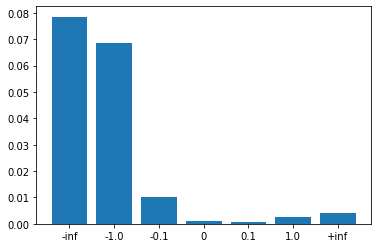

In [41]:
plt.bar(q_list, [s/20000 for s in scores])